Ref: https://youtu.be/vV12dGe_Fho?si=72pTPJWbm-cqJ1v0

In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 116.8 MB/s  0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Ref: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

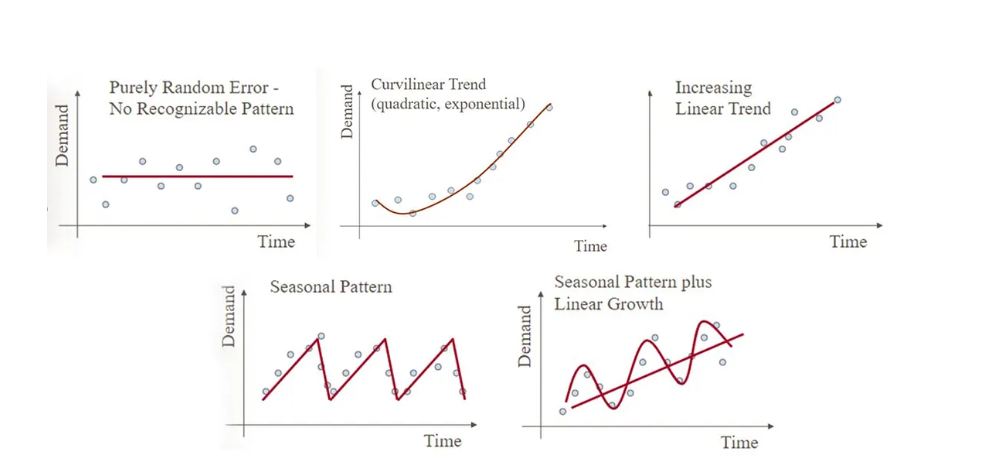

* Purely Random Error
    * Demand isn’t really changing over time. The ups and downs are just random noise — like flipping a coin.
* Curvilinear Trend
    * Demand is growing, and it’s speeding up — like a snowball rolling downhill and getting faster.
* Increasing Linear Trend
    * Demand is rising steadily — same amount of growth each time period.
* Seasonal Pattern
    * Demand goes through cycles — like higher in summer, lower in winter — but overall stays flat.
* Seasonal Pattern + Linear Growth
    * Demand is growing over time and still has seasonal ups and downs — like more sales every summer, and each summer is better than the last.

In [5]:
import io
import boto3
import pandas as pd

s3_uri = "s3://spoofing-ml-exp/Example Data/PJME_hourly.csv"
bucket_name = s3_uri.replace("s3://", "").split("/")[0]
key = "/".join(s3_uri.replace("s3://", "").split("/")[1:])

s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket_name, Key=key)
df = pd.read_csv(io.BytesIO(obj["Body"].read()))
print(df.shape, df.head())


(145366, 2)               Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0


In [8]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

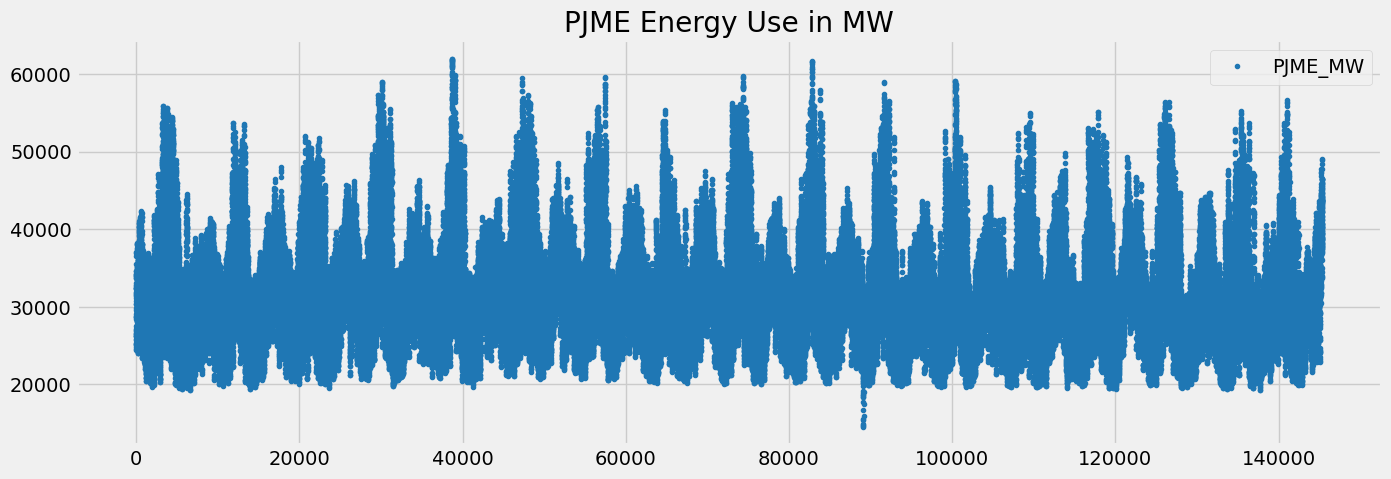

In [6]:
# Create a scatter plot from the DataFrame using dots as markers
df.plot(style='.',           # Use dots/points as markers instead of lines
        figsize=(15, 5),     # Set the figure size to 15 inches wide by 5 inches tall
        color=color_pal[0],  # Use the first color from the color_pal list/array for the plot
        title='PJME Energy Use in MW')  # Set the plot title to describe the data

# Display the plot in the output (required in most Python environments)
plt.show()

### Train/Test Split

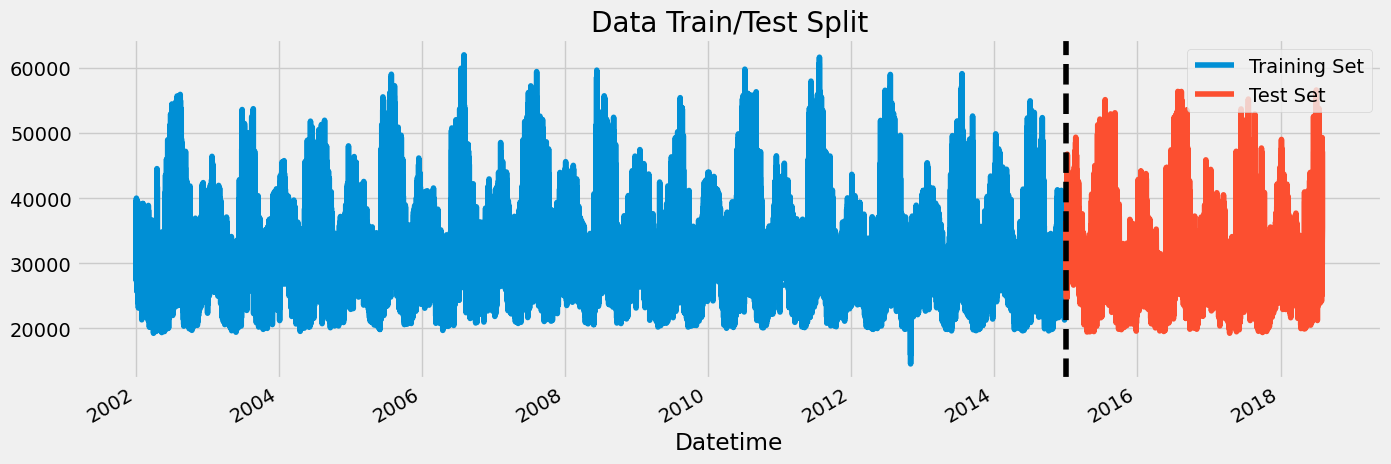

In [9]:
# Split the data into training and test sets based on date
train = df.loc[df.index < '01-01-2015']    # Training data: all records before January 1, 2015
test = df.loc[df.index >= '01-01-2015']    # Test data: all records from January 1, 2015 onwards

# Create a figure and axis with specified size
fig, ax = plt.subplots(figsize=(15, 5))    # Create subplot with 15x5 inch figure size

# Plot the training data on the axis
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')  # Plot training data with label and title

# Plot the test data on the same axis
test.plot(ax=ax, label='Test Set')         # Plot test data with label (different color automatically)

# Add a vertical line to mark the split point
ax.axvline('01-01-2015', color='black', ls='--')  # Draw black dashed vertical line at split date

# Add a legend to distinguish between datasets
ax.legend(['Training Set', 'Test Set'])    # Create legend with labels for both datasets

# Display the plot
plt.show()                                 # Show the completed plot

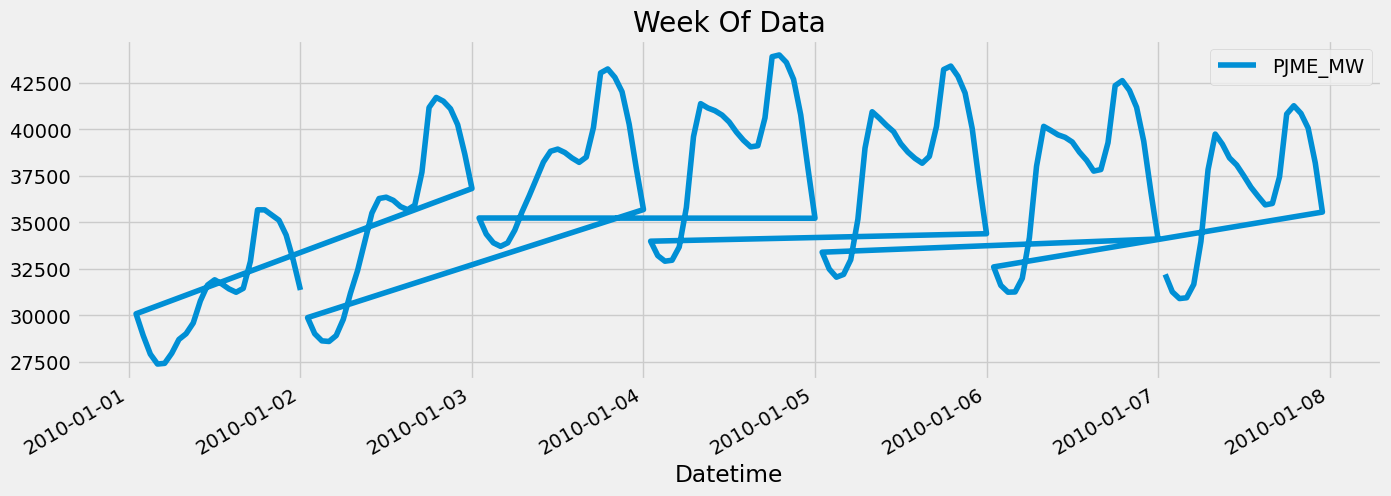

In [13]:
# Filter data for a specific week in January 2010 and plot it
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')  # Select data between Jan 1-8, 2010 and plot with size/title

# Display the plot
plt.show()  # Show the completed plot

### Feature Creation

In [14]:
# Define a function to extract time-based features from datetime index
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()                                          # Create a copy to avoid modifying original DataFrame
    df['hour'] = df.index.hour                              # Extract hour of day (0-23)
    df['dayofweek'] = df.index.dayofweek                    # Extract day of week (0=Monday, 6=Sunday)
    df['quarter'] = df.index.quarter                        # Extract quarter of year (1-4)
    df['month'] = df.index.month                            # Extract month of year (1-12)
    df['year'] = df.index.year                              # Extract year
    df['dayofyear'] = df.index.dayofyear                    # Extract day of year (1-366)
    df['dayofmonth'] = df.index.day                         # Extract day of month (1-31)
    df['weekofyear'] = df.index.isocalendar().week          # Extract ISO week of year (1-53)
    return df                                               # Return DataFrame with new feature columns

# Apply the feature creation function to the DataFrame
df = create_features(df)                                    # Add all time-based features to the existing DataFrame

### Visualize our Feature / Target Relationship

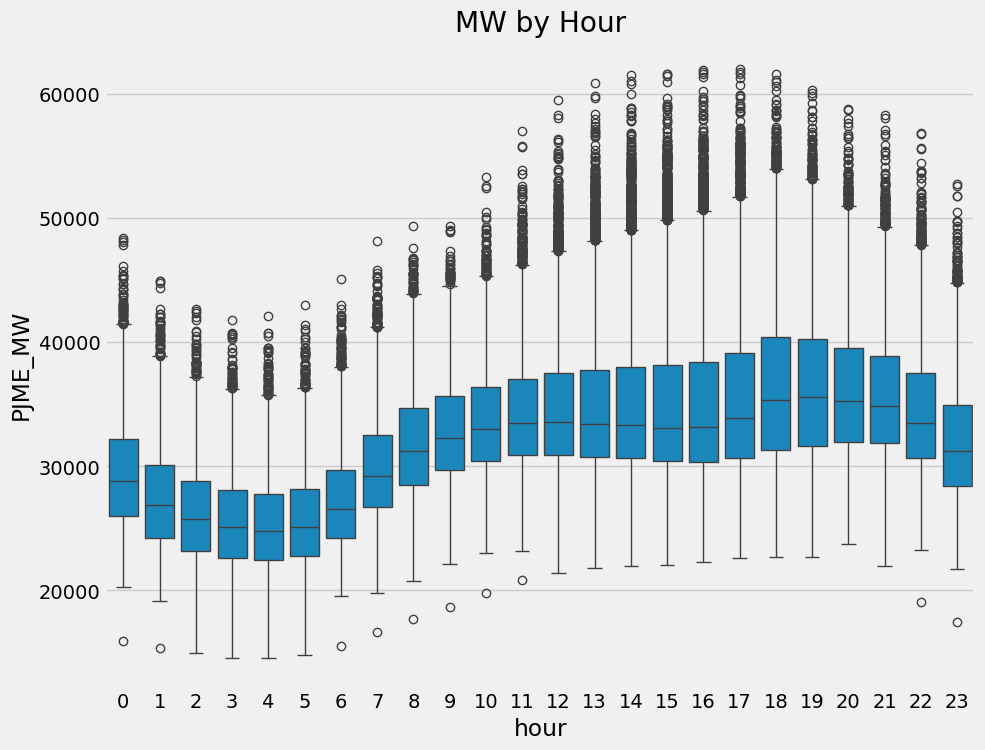

In [15]:
# Create a boxplot to show energy usage patterns by hour of day
fig, ax = plt.subplots(figsize=(10, 8))              # Create figure and axis with 10x8 inch size
sns.boxplot(data=df, x='hour', y='PJME_MW')          # Create boxplot with hour on x-axis, energy usage on y-axis
ax.set_title('MW by Hour')                           # Set the plot title
plt.show()                                           # Display the completed plot

/tmp/ipykernel_14067/2515332187.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues') # Create boxplot with month on x-axis, energy usage on y-axis, blue color scheme


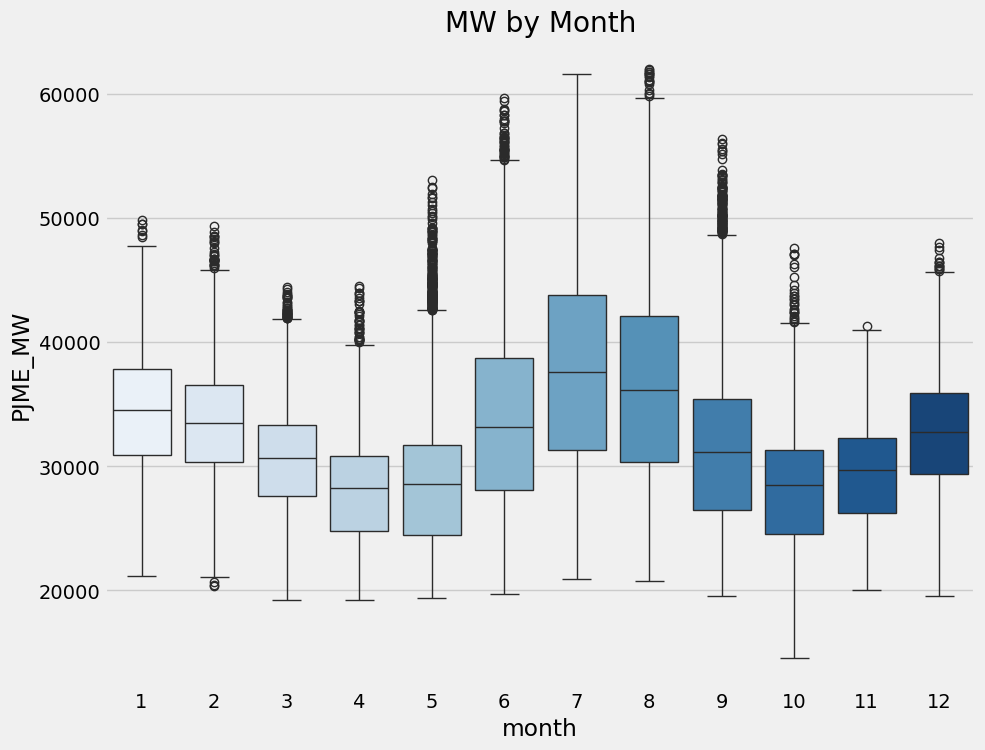

In [16]:
# Create a boxplot to show energy usage patterns by month of year
fig, ax = plt.subplots(figsize=(10, 8))                     # Create figure and axis with 10x8 inch size
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues') # Create boxplot with month on x-axis, energy usage on y-axis, blue color scheme
ax.set_title('MW by Month')                                 # Set the plot title
plt.show()                                                  # Display the completed plot

### Create our Model

In [17]:
# Prepare training and test datasets with features for machine learning
train = create_features(train)                              # Add time-based features to training dataset
test = create_features(test)                                # Add time-based features to test dataset

# Define which columns to use as features and target variable
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']  # List of feature columns for model input
TARGET = 'PJME_MW'                                          # Target variable (energy consumption to predict)

# Split training data into features (X) and target (y)
X_train = train[FEATURES]                                   # Training features: select only the specified feature columns
y_train = train[TARGET]                                     # Training target: energy consumption values

# Split test data into features (X) and target (y)
X_test = test[FEATURES]                                     # Test features: select only the specified feature columns
y_test = test[TARGET]                                       # Test target: energy consumption values for evaluation

In [18]:
# Create and configure an XGBoost regression model
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    # Initialize XGBoost regressor with base prediction of 0.5 and gradient boosting trees
                       n_estimators=1000,                   # Maximum number of boosting rounds (trees to build)
                       early_stopping_rounds=50,            # Stop training if no improvement for 50 consecutive rounds
                       objective='reg:linear',               # Use linear regression objective for continuous target values
                       max_depth=3,                          # Maximum depth of each tree (controls model complexity)
                       learning_rate=0.01)                   # Step size shrinkage to prevent overfitting (lower = more conservative)

# Train the model with validation monitoring
reg.fit(X_train, y_train,                                   # Fit model using training features and target
        eval_set=[(X_train, y_train), (X_test, y_test)],    # Monitor performance on both training and test sets during training
        verbose=1)                                         # Print training progress every 1 rounds

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[1]	validation_0-rmse:32286.40387	validation_1-rmse:31338.35548
[2]	validation_0-rmse:31970.92515	validation_1-rmse:31022.82517
[3]	validation_0-rmse:31658.67497	validation_1-rmse:30710.54618
[4]	validation_0-rmse:31349.61580	validation_1-rmse:30403.04162
[5]	validation_0-rmse:31043.71359	validation_1-rmse:30097.13477
[6]	validation_0-rmse:30740.94175	validation_1-rmse:29795.93347
[7]	validation_0-rmse:30441.26143	validation_1-rmse:29496.27413
[8]	validation_0-rmse:30144.64955	validation_1-rmse:29201.25018
[9]	validation_0-rmse:29851.07579	validation_1-rmse:28907.72364
[10]	validation_0-rmse:29560.50774	validation_1-rmse:28618.76046
[11]	validation_0-rmse:29272.91646	validation_1-rmse:28331.47224
[12]	validation_0-rmse:28988.27243	validation_1-rmse:28048.45508
[13]	validation_0-rmse:28706.54403	validation_1-rmse:27767.05438
[14]	validation_0-rmse:28427.71157	validation_1-rmse:27489.86317
[15]	validation_0-rmse:28151.73487	

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [05:01:40] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[25]	validation_0-rmse:25536.63057	validation_1-rmse:24609.61601
[26]	validation_0-rmse:25290.05744	validation_1-rmse:24364.86788
[27]	validation_0-rmse:25044.53979	validation_1-rmse:24120.15620
[28]	validation_0-rmse:24803.06545	validation_1-rmse:23878.49994
[29]	validation_0-rmse:24564.08931	validation_1-rmse:23641.24404
[30]	validation_0-rmse:24326.08921	validation_1-rmse:23403.75450
[31]	validation_0-rmse:24092.08227	validation_1-rmse:23169.87995
[32]	validation_0-rmse:23858.67068	validation_1-rmse:22936.70500
[33]	validation_0-rmse:23629.38822	validation_1-rmse:22707.78582
[34]	validation_0-rmse:23400.73829	validation_1-rmse:22479.40788
[35]	validation_0-rmse:23176.15754	validation_1-rmse:22256.18006
[36]	validation_0-rmse:22952.05228	validation_1-rmse:22032.41916
[37]	validation_0-rmse:22732.08944	validation_1-rmse:21812.89087
[38]	validation_0-rmse:22512.55892	validation_1-rmse:21593.95973
[39]	validation_0-rmse:22297.16250	validation_1-rmse:21378.89558
[40]	validation_0-rmse:22

,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


### Feature Importance

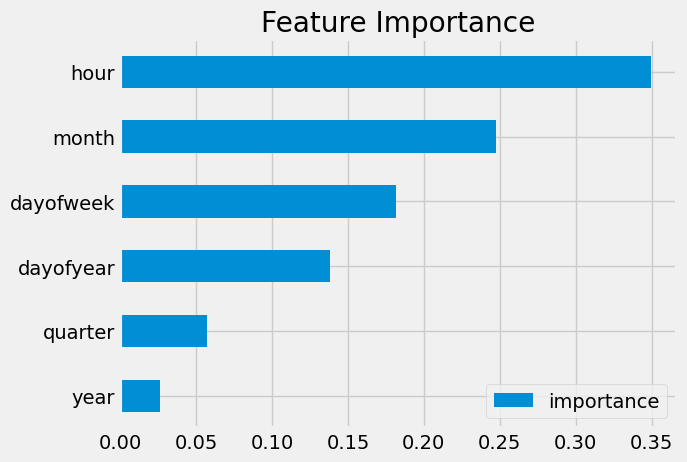

In [19]:
# Create and visualize feature importance from the trained XGBoost model
fi = pd.DataFrame(data=reg.feature_importances_,            # Extract feature importance scores from trained model
             index=reg.feature_names_in_,                   # Use feature names as row indices
             columns=['importance'])                        # Name the column 'importance'

# Create horizontal bar plot of feature importance
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')  # Sort by importance and create horizontal bar chart
plt.show()                                                  # Display the feature importance plot

### Forecast on Test

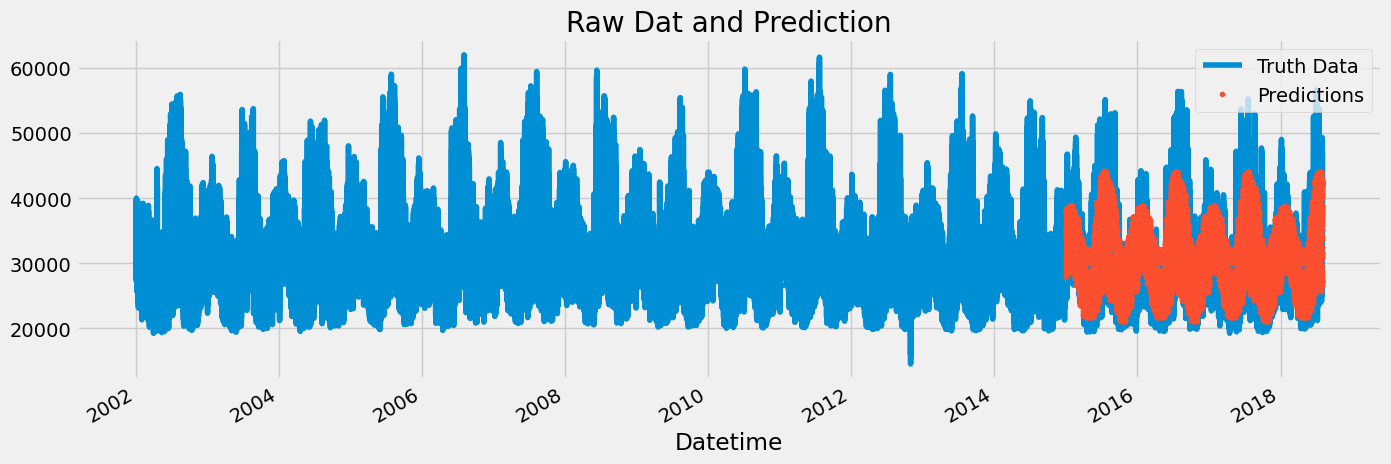

In [20]:
# Generate predictions and visualize model performance
test['prediction'] = reg.predict(X_test)                   # Generate predictions using trained model on test features
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)  # Merge predictions back into original DataFrame using index

# Create comparison plot of actual vs predicted values
ax = df[['PJME_MW']].plot(figsize=(15, 5))                 # Plot actual energy usage data as line plot
df['prediction'].plot(ax=ax, style='.')                    # Plot predictions as dots on same axis
plt.legend(['Truth Data', 'Predictions'])                  # Add legend to distinguish actual vs predicted
ax.set_title('Raw Dat and Prediction')                     # Set plot title (note: typo in 'Dat')
plt.show()                                                  # Display the comparison plot

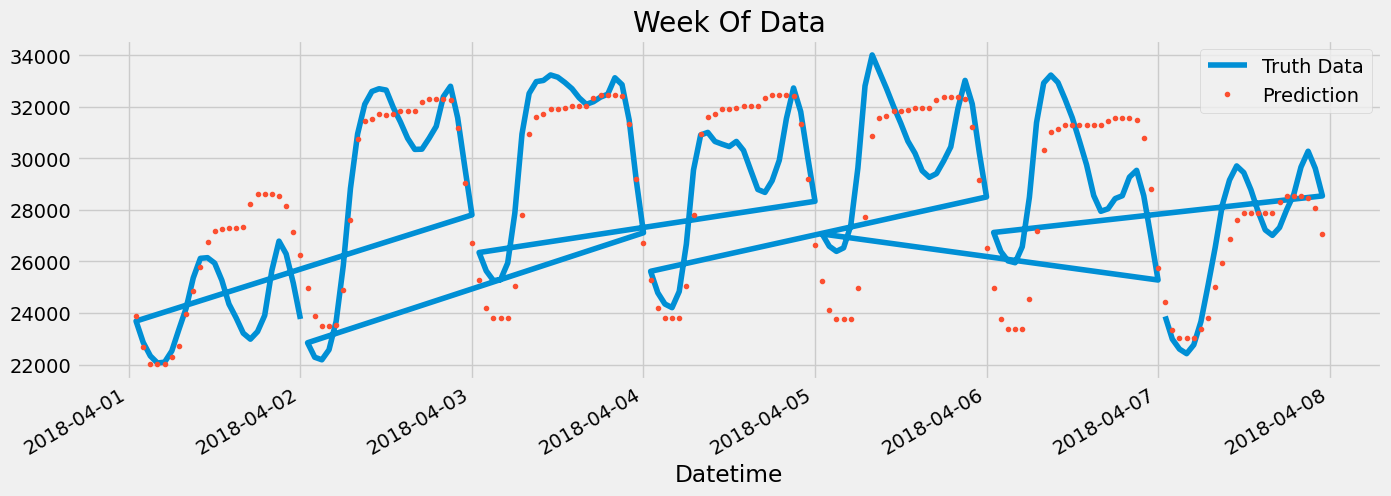

In [21]:
# Create a detailed comparison plot for one week of data
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')           # Filter data between April 1-8, 2018 and plot actual energy usage as line
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')                                       # Filter same date range and plot model predictions as dots
plt.legend(['Truth Data','Prediction'])                    # Add legend to distinguish between actual and predicted values
plt.show()                                                 # Display the weekly comparison plot

### Score (RMSE)

In [22]:
# Calculate and display the Root Mean Squared Error (RMSE) for model evaluation
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))  # Calculate RMSE between actual and predicted values
print(f'RMSE Score on Test set: {score:0.2f}')            # Print RMSE score formatted to 2 decimal places

RMSE Score on Test set: 3726.80


### Calculate Error

In [23]:
# Calculate prediction errors and identify dates with highest average errors
test['error'] = np.abs(test[TARGET] - test['prediction'])  # Calculate absolute error between actual and predicted values
test['date'] = test.index.date                             # Extract date (without time) from datetime index
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)  # Group by date, calculate mean error per day, sort highest first, show top 10

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64